# Import Data

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

df = pd.read_csv('../Data/final_data.csv', dtype={'fullVisitorId': 'str'})
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717217 entries, 0 to 717216
Data columns (total 30 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               717217 non-null  object 
 1   date                                          717217 non-null  object 
 2   device_browser                                717217 non-null  object 
 3   device_deviceCategory                         717217 non-null  object 
 4   device_isMobile                               717217 non-null  bool   
 5   device_operatingSystem                        717217 non-null  object 
 6   fullVisitorId                                 717217 non-null  object 
 7   totals_hits                                   717217 non-null  int64  
 8   totals_pageviews                              717217 non-null  float64
 9   totals_sessionQualityDim                      71

Most visits to the store appear to result in 0 or low revenue, but there are some outliers.  The largest purchase is for $23k. 

<AxesSubplot:xlabel='revenue_usd'>

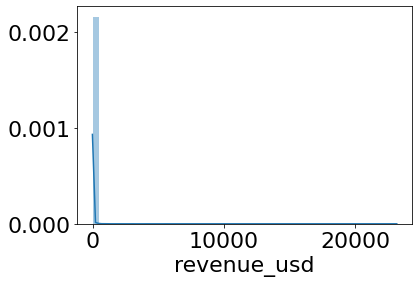

In [32]:
sns.distplot(df['revenue_usd'])

# Purchase vs Non-Purchase

Now we examine how many visits end in a purchase vs no purchase.  The vast majority of site visits end without a purchase of any size being made.

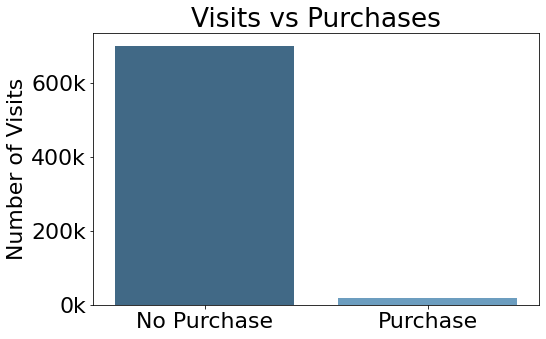

In [33]:
df['purchase'].value_counts()
plt.subplots(figsize=(8, 5))
ax = sns.barplot(x=['No Purchase', 'Purchase'], y=df['purchase'].value_counts(), palette='Blues_d')
plt.ylabel('Number of Visits')
plt.title('Visits vs Purchases')
plt.rcParams.update({'font.size': 22})
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: str(round(y / 1000)) + 'k'))

# EDA for site visits that result in purchases

Only 2.46% of site visits end with a purchase of any amount.  Of the visits that end in a purchase, most are under 100 dollars in total.  The average purchase size is $124.

In [34]:
purchases = df.loc[df['totals_transactionRevenue'] != 0]

2.46% of site visitors made a purchase.
The average purchase value is: $124.47


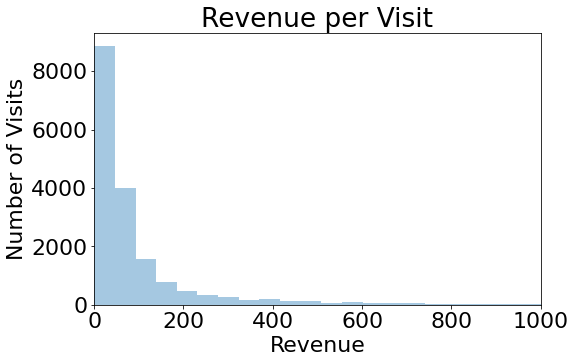

In [35]:
plt.subplots(figsize=(8, 5))
sns.distplot(purchases['revenue_usd'], bins=500, kde=False)
plt.xlim(0, 1000)
plt.xlabel('Revenue')
plt.ylabel('Number of Visits')
plt.title('Revenue per Visit')
plt.rcParams.update({'font.size': 22})


percent_purchase = round(purchases['visitId'].count() / df['visitId'].count() * 100, 2)
print(str(percent_purchase) + "% of site visitors made a purchase.")
print("The average purchase value is: $" + str(round(purchases['revenue_usd'].mean(), 2)))

Of those visitors that make a purchase, the majority of them spend less than 100 dollars.  Average purchase size is $124.47.  Only 2.5% of visits result in a sale of any amount.

# Mobile vs Not

Here we examine spending on mobile devices vs desktop (or similar) devices.  The average purchase size on mobile devices is less than half of the average total from a non-mobile device.  

This could be due to a poor mobile interface or lack of user trust in making large purchases on their phones.

In [37]:
count_mobile = purchases.groupby('device_isMobile').count()
avg_mobile = purchases.groupby('device_isMobile').mean()

Text(0.5, 1.0, 'Average Purchase Amount on Mobile')

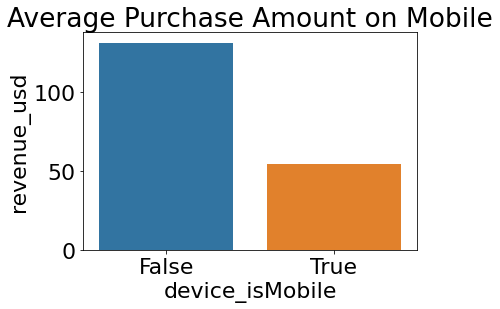

In [38]:
sns.barplot(y=avg_mobile['revenue_usd'], x= avg_mobile.index)
plt.title('Average Purchase Amount on Mobile')

In addition to a smaller average cart size, mobile users also make fewer purchases overall:

Text(0.5, 1.0, 'Number of Purchases on Mobile')

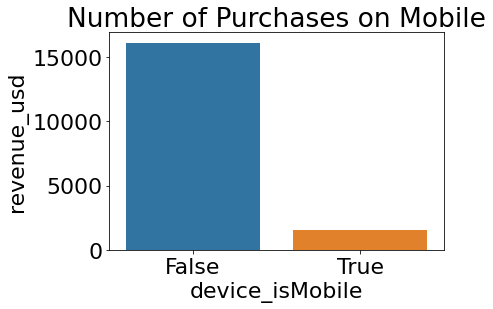

In [39]:
sns.barplot(y=count_mobile['revenue_usd'], x= count_mobile.index)
plt.title('Number of Purchases on Mobile')

# What Percent of Visits End with a Purchase?

Now we examine trends in purchases over time.  In this section we modify our data to time series format and graph trends based on a 4 week rolling average.

In [40]:
def percent_purchase(df, unit_of_time):
    df['date'] = df['date'].astype(str)
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    
    #Get number of purchases per time unit
    df_ts = df[['date', 'purchase']]
    df_ts_gr = df_ts.groupby('date').sum()
    purchases = df_ts_gr.resample(unit_of_time).sum()
    
    #Get number of visits per time unit
    df_ts = df[['date', 'purchase']]
    df_ts_gr = df_ts.groupby('date').count()
    visits = df_ts_gr.resample(unit_of_time).sum()
    visits['visits'] = visits['purchase']
    visits.drop('purchase', axis=1, inplace=True)
    
    #Combine purchases and visits
    df_time = purchases.join(visits, how='inner')
    
    #Calculate percent
    df_time['percent_purchase'] = df_time['purchase'] / df_time['visits'] * 100
    
    return df_time

In [41]:
df_weekly = percent_purchase(df, 'W')
df_monthly = percent_purchase(df, 'M')

### Weekly % Purchases (Rolling 4 Week Avg)

In [43]:
def graph_roll_avg_percent_purchase(df, window):
    rolling_mean = df.rolling(window=window, center=False).mean()
    plt.subplots(figsize=(12, 6))
    ax = sns.lineplot(x=rolling_mean.index, y="percent_purchase", data=rolling_mean)
    plt.ylabel('% Purchase')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title('Percent Purchase - 4 Week Rolling Average')
    plt.rcParams.update({'font.size': 22})


def graph_roll_avg_visits(df, window):
    rolling_mean = df.rolling(window=window, center=False).mean()
    plt.subplots(figsize=(12, 6))
    ax = sns.lineplot(x=rolling_mean.index, y="visits", data=rolling_mean)
    plt.ylabel('# of Visits')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.title('Weekly Visits- 4 Week Rolling Average')
    plt.rcParams.update({'font.size': 22})


In any week, about 2.5% to 3.5% of visits ended with a purchase.  This changed in October 2017, when the average percent of visits that result in a purchase declined to about 1.5%.

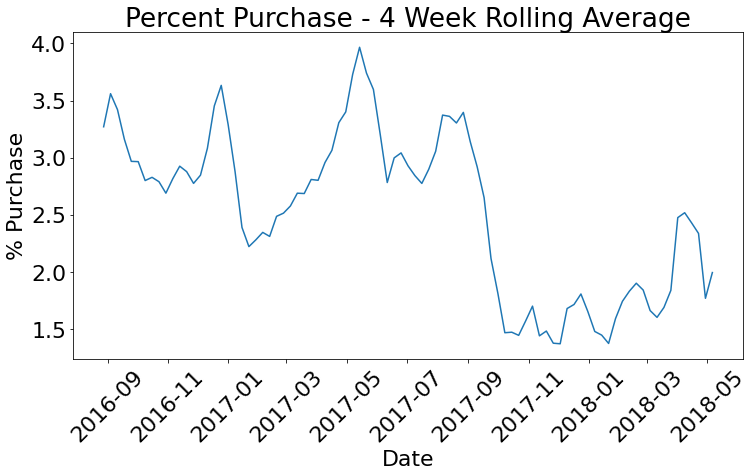

In [44]:
graph_roll_avg_percent_purchase(df_weekly, 4)

One reason for this decrease in the percent of visits that lead to purchases is an increase in overall visits to the site in October 2017.  This corresponds to a large drop of new products from Google.  One possible explanation is that these new products inspired new people to visit the store, but they were not as enthusiastic about buying Google products as previous customers.

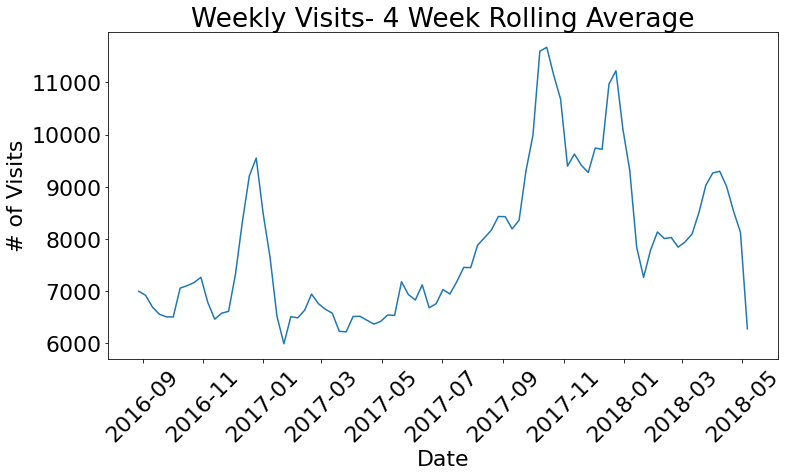

In [45]:
graph_roll_avg_visits(df_weekly, 4)

# What Percent of Visits End with a Purchase?  Mobile vs Not

Now we will repeat the same analysis we did above, while breaking purchases out into those from mobile vs non-mobile devices.

In [46]:
mobile = df.loc[df['device_isMobile'] == True]
non_mobile = df.loc[df['device_isMobile'] == False]

In [47]:
weekly_mobile = percent_purchase(mobile, 'W')
weekly_non_mobile = percent_purchase(non_mobile, 'W')

<ipython-input-40-2431eecb7bad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['date'].astype(str)
<ipython-input-40-2431eecb7bad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']).dt.normalize()


### % Purchase - Mobile vs Non-Mobile

The trends are similar to what we saw above, but the swings in purchase percent are less pronounced for mobile visits. 

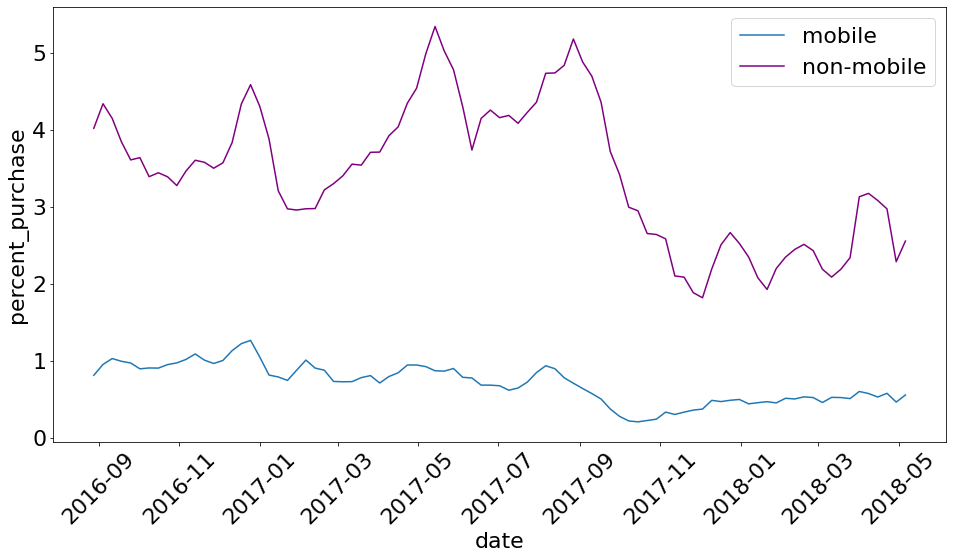

In [58]:
#Graph % for mobile
mobile_rolling_mean = weekly_mobile.rolling(window=4, center=False).mean()
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x=mobile_rolling_mean.index, y="percent_purchase", data=mobile_rolling_mean, label='mobile')
plt.xticks(rotation=45)


#Graph % for non-mobile
non_rolling_mean = weekly_non_mobile.rolling(window=4, center=False).mean()
ax2 = sns.lineplot(x=non_rolling_mean.index, y="percent_purchase", data=non_rolling_mean, color='purple', label='non-mobile')


### Visits per Week - Mobile vs Non-Mobile

Here we can pinpoint the spike in (low purchase rate) mobile visits that lead to the drop in the overall purchase rate.

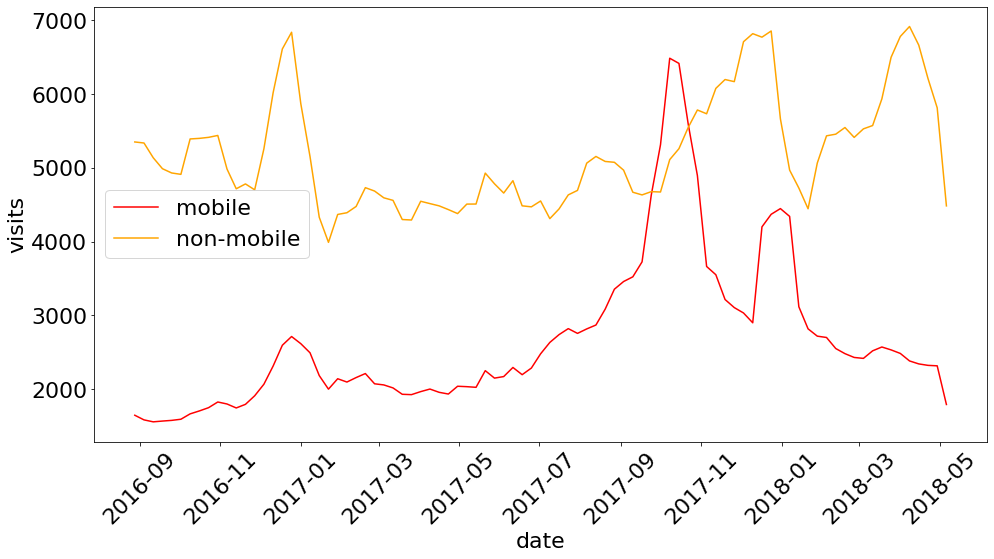

In [59]:
# Mobile visits
plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x=mobile_rolling_mean.index, y="visits", data=mobile_rolling_mean, color='red', label = 'mobile')
plt.xticks(rotation=45)


# Non-mobile visits
ax2 = sns.lineplot(x=non_rolling_mean.index, y="visits", data=non_rolling_mean, color='orange', label='non-mobile')
plt.legend()

# Averages by OS

Now we analyze how spending differs based on the operating system of the device that is browsing the store.

In [50]:
df_os = df.loc[df['revenue_usd'] != 0]
df_os_purchase = df_os.groupby('device_operatingSystem').mean().sort_values(by='revenue_usd', ascending=False)

### Avg Spend (of those who made a purchase)

The average purchase size is largest for Windows and Chrome OS machines.  Chrome OS is a Google product, so it makes sense that people who already own Google products would tend to buy more Google products.

Text(0.5, 1.0, 'Average Purchase Amount by Operating System')

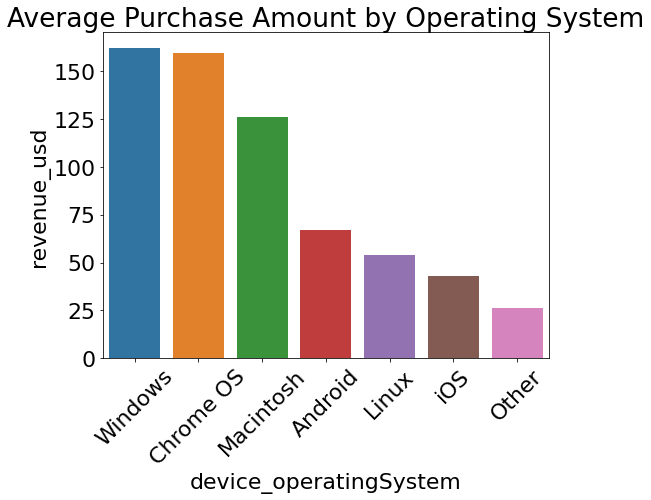

In [61]:
plt.subplots(figsize=(8, 6))
sns.barplot(y=df_os_purchase['revenue_usd'], x= df_os_purchase.index)
plt.xticks(rotation=45)
plt.title('Average Purchase Amount by Operating System')

### Avg % Purchase

Counterintuitively, we see that a large portion of Mac users make a purchase, while a much smaller proportion of Chrome OS users do.

Text(0.5, 1.0, 'Percent of Visits that End in Purchase: by Operating System')

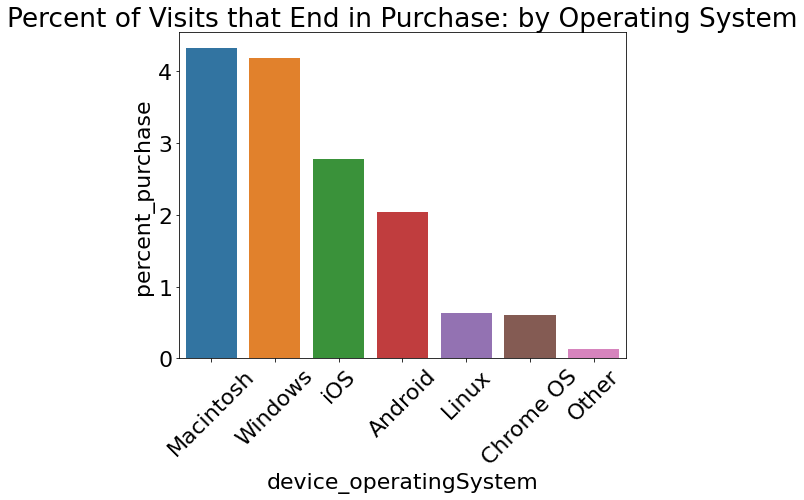

In [62]:
# Groupby OS Count
count = df.groupby('device_operatingSystem').count().sort_values(by='revenue_usd', ascending=False)
count = count[['visitId']]

# Group by OS Sum
total = df.groupby('device_operatingSystem').sum().sort_values(by='revenue_usd', ascending=False)
total = total[['purchase']]

# Calculate Percent
joined = count.join(total, how='inner')
joined['percent_purchase'] = joined['purchase'] / joined['visitId'] * 100

# Graph Percent
plt.subplots(figsize=(8, 6))
sns.barplot(y=joined['percent_purchase'].sort_values(ascending=False), x= joined.index)
plt.xticks(rotation=45)
plt.title('Percent of Visits that End in Purchase: by Operating System')

# Averages by Browser

In [53]:
df_brow = df.loc[df['revenue_usd'] != 0]
df_brow_purchase = df_brow.groupby('device_browser').mean().sort_values(by='revenue_usd', ascending=False)

### Avg Spend (of those who made a purchase)

Firefox users buy far larger amounts than visitors using any other browser.  This could be due to large outlier purchases made by a few Firefox users.  More investigation is warranted.

Text(0.5, 1.0, 'Average Purchase Amount by Browser')

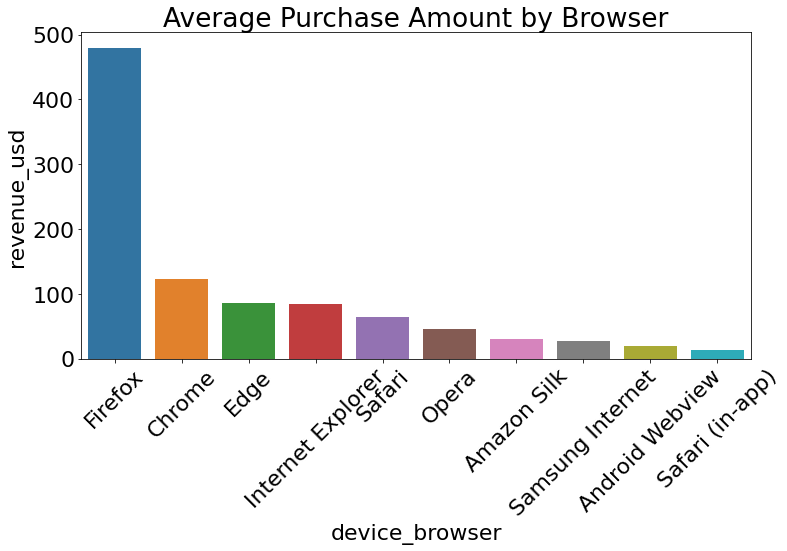

In [63]:
plt.subplots(figsize=(12, 6))
sns.barplot(y=df_brow_purchase['revenue_usd'], x= df_brow_purchase.index)
plt.xticks(rotation=45)
plt.title('Average Purchase Amount by Browser')

### Avg % Purchase

Users that visit the store using Google Chrome make purchases at the highest rate.

Text(0.5, 1.0, 'Percent of Visits that End in Purchase: by Browser')

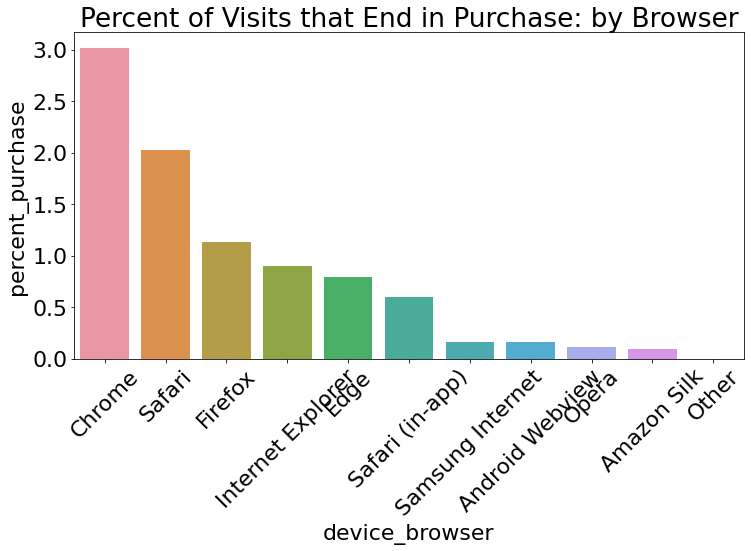

In [64]:
# Groupby OS Count
count = df.groupby('device_browser').count().sort_values(by='revenue_usd', ascending=False)
count = count[['visitId']]

# Group by OS Sum
total = df.groupby('device_browser').sum().sort_values(by='revenue_usd', ascending=False)
total = total[['purchase']]

# Calculate Percent
joined = count.join(total, how='inner')
joined['percent_purchase'] = joined['purchase'] / joined['visitId'] * 100

# Graph Percent
plt.subplots(figsize=(12, 6))
sns.barplot(y=joined['percent_purchase'].sort_values(ascending=False), x= joined.index)
plt.xticks(rotation=45)
plt.title('Percent of Visits that End in Purchase: by Browser')